In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/Users/arturoreza/Documents/isac_2025/events_360_data_game_state/events_df_Liga_MX_2021_2022.csv')

/var/folders/mm/5rp42wfn61b3g1r33d3fnfvc0000gn/T/ipykernel_10793/1340678120.py:1: DtypeWarning: Columns (2,3,7,9,10,11,17,21,22,24,28,29,30,31,32,33,35,38,39,41,43,44,45,46,47,48,51,52,55,61,77,78,80,82,84,85,87,95,98,104,111,113,116,122,123,125,126,127,130) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/arturoreza/Documents/isac_2025/events_360_data_game_state/events_df_Liga_MX_2021_2022.csv')


In [3]:
# Helper: parse timestamp "HH:MM:SS.mmm" -> total seconds (float)
def ts_to_seconds(ts):
    if pd.isna(ts):
        return None
    h, m, s = ts.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

In [5]:
# Ensure chronological order within period & teams (as a proxy for match)
df['time_seconds'] = df['timestamp'].apply(ts_to_seconds)
sort_cols = [c for c in ['home_team', 'away_team', 'period', 'time_seconds'] if c in df.columns]
if sort_cols:
    df = df.sort_values(sort_cols).reset_index(drop=True)

In [6]:
# Identify corner-pass execution rows
mask_corner_exec = (
    (df.get('play_pattern') == "From Corner") &
    (df.get('pass_type') == "Corner") &
    (df.get('type') == "Pass")
)

# Previous event time within the same game segment (home/away/period)
group_cols = [c for c in ['home_team', 'away_team', 'period'] if c in df.columns]
if group_cols:
    df['prev_time_in_group'] = df.groupby(group_cols)['time_seconds'].shift(1)
else:
    df['prev_time_in_group'] = df['time_seconds'].shift(1)

# Create requested column: corner_execution_time_raw (seconds)
df['corner_execution_time_raw'] = None
df.loc[mask_corner_exec, 'corner_execution_time_raw'] = (
    df.loc[mask_corner_exec, 'time_seconds'] - df.loc[mask_corner_exec, 'prev_time_in_group']
)

In [7]:
# Drop helper columns used in calculation (keep only the clean new column)
drop_cols = [c for c in ['time_seconds', 'prev_time_in_group'] if c in df.columns]
df = df.drop(columns=drop_cols)


In [8]:
df.to_csv('events_df_Liga_MX_2021_2022.csv')

<Axes: >

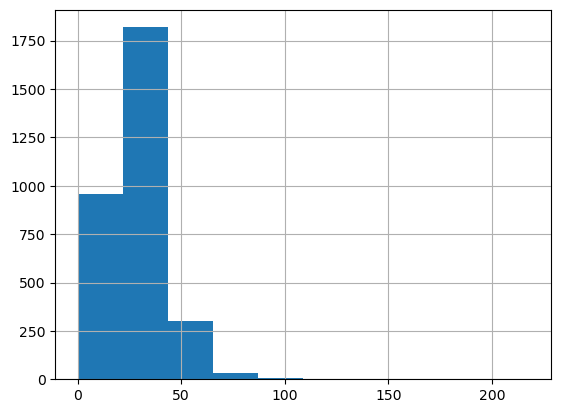

In [13]:
df['corner_execution_time_raw'].hist()